# **Plant Recognition - Lucifern**

*After we did our research, we found that there is a lot of CNN's models that can be used for image classification so we decided to try them and see how they perform. Here is a list of the models we found:*

1. Vgg16
2. Resnet50
4. EfficientNet
5. Xception
6. GoogleNet

*After investigation more, we found that pytorch has a list of models that we can use: for example, vgg and its different versions, resnet and its different versions and so on.*

# **Step 1:**
# *Importing the libraries*

In [ ]:
import pandas as pd 
import random
import os 
from PIL import Image
import glob 

# Import Pytorch
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


# A package to make beautiful progress bars :) 
from tqdm.notebook import tqdm

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

*Function for displaying the images after loading them*

In [ ]:
def display_tensor(t):
    trans=transforms.ToPILImage()
    display(trans(t))

# **Step 2:** loading the dataset

**step 2.1:** function to load the dataset which applies some pre-processing on it. The transformations include resizing the images, performing some data-augmentation on the dataset like flipping horizantally and vertically to improve the models' performance by introducing them as new images to the train dataset since in machine learning everything is data-driven. The more data you have, the better and more accurate your model will be. We also scaled the data in order to speed up the training (but unfortunately this wasn't enough). We used the ImageFolder function since every plant class is arranged into a folder.

In [ ]:
def load_dataset(root_path, dir):

    transform = transforms.Compose(
        [  # Applying Augmentation
        torchvision.transforms.Resize(224),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ])
    
    
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    return data 

**Step 2.3:**
*storing the dataset in the variable train_data and checking its length*

In [ ]:
train_data= load_dataset("/kaggle/input/polytech-nice-data-science-course-2021/polytech/","train")
len(train_data)

**Step 2.4:** *taking some samples of the dataset*

In [ ]:
for i in range(9):
    sample= train_data[i]
    display_tensor(sample[0])

*printing the all the classes of the plants' dataset*

In [ ]:
train_data.classes

*The ImageFolder function maps the classes to indexes*

In [ ]:
train_data.class_to_idx

*The Plant dataset is imbalanced which explains why we have accuracies in some classes more than the others. This can be better visualized by running the following cell which displays a histogram with the count of images for each class*

In [ ]:
t = dict([(i, [x for x in train_data.targets].count(i)) for i in range(0,152)])

labels = [i+1 for i in range(152)]

x = np.arange(len(labels)) 
width = 0.8  

fig, ax = plt.subplots(figsize=(22,10))
rects1 = ax.bar(x, list(t.values()), width, label='classes')

ax.set_ylabel('Number of images')
ax.set_title('Number of images of each class in the dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

Split the dataset into 85% for training and 15% for validation.
After running and trying different models, we decided to change the length of the validation dataset and study its effect on the best model (Xception). We concluded that the best split would be 15% for validation and 85% for training.

In [ ]:
val_length = int(0.15*len(train_data))

train_set, val_set= torch.utils.data.random_split(train_data, 
                                                             [len(train_data) - val_length,
                                                             val_length])
                                                           

train_dl = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=8,shuffle=True)

print(len(train_set))
print(len(val_set))

# Their sizes should be correct
len(train_set) + len(val_set) == len(train_data)

**Trying with EfficientNet model**: *After reading about efficientNet, we concluded that the best model to use is efficientNet-b7, but unfortunately efficientNet b7, b6, b5 and b4 need a lot of computational power so even after reducing the batch size to 16, it didn't work because CUDA was out of memory.*


*The model we used was efficientNet-b3, it gave an accuracy of 0.71 on testing data*

In [ ]:
# def efficientNet():

#     net = EfficientNet.from_pretrained('efficientnet-b3')

#     # Move model to the GPU
#     net = net.cuda()
    
#     # Define images transformations (pre processing)
#     convert = transforms.Compose(
#         [  # Applying Augmentation
#         torchvision.transforms.Resize((224, 224)),
#         torchvision.transforms.RandomHorizontalFlip(p=0.5),
#         torchvision.transforms.RandomVerticalFlip(p=0.5),
#         torchvision.transforms.RandomRotation(30),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#         ),
#     ])



#     # Negative log likelihood loss
#     criterion = nn.CrossEntropyLoss(reduction="mean").cuda()

#     # Stochastic Gradient Descent
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.007)
    
#     return net, convert, criterion, optimizer

# print("done")


# net, convert, criterion, optimizer = efficientNet()

**Trying with googleNet model:** *GoogleNet model gave an accuracy 86% for training and 81% on testing*

In [ ]:
# LEARNING_RATE = 0.001
# net = torchvision.models.googlenet(pretrained=True)

# # Move model to the GPU

# criterion = nn.CrossEntropyLoss().cuda()
# net= net.cuda()

# # Stochastic Gradient Descent
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

**Trying with Xception model:** *Xception model gave an accuracy 89% for training and 84% on testing*

In [ ]:
#from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py
import math
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

model_urls = {
    'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

*We used cross entropy loss because we have a classification problem, we trained the model with adam optimizer and with SGD(with momentum = 0.9) but the accuracy seems to be very very close*

In [ ]:
def xception():

    net = Xception()
    net.load_state_dict(model_zoo.load_url(model_urls['xception']))

    # Move model to the GPU
    net = net.cuda()
    
    # Define images transformations (pre processing)
    convert = transforms.Compose(
        [  # Applying Augmentation
        torchvision.transforms.Resize(224),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ])


    # Negative log likelihood loss
    criterion = nn.CrossEntropyLoss().cuda()

    # Stochastic Gradient Descent
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    return net, convert, criterion, optimizer

net, convert, criterion, optimizer = xception()

*Trying with resnet50 and resnet152 with batch_size= 32.*
*Using resnet50, we got an accuracy of 79% for training and 74% for testing*. Using resnet152, the model took very long to train and reaches 12 epochs before exceeding the GPU quota. it was 74% on training but we couldn't test it.

In [ ]:
#net = torchvision.models.resnet50(pretrained=True)
#net = torchvision.models.resnet152(pretrained=True)
#num_ftrs = net.fc.in_features
#print(num_ftrs)
#net.fc = nn.Linear(num_ftrs, 153)
 

# # Move model to the GPU

# criterion = nn.CrossEntropyLoss().cuda()
# net= net.cuda()

# # Stochastic Gradient Descent
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

*Trying with vgg16: We got an accuracy of 80% for training and for testing we got 74%*

In [ ]:
#     def vgg16():

#     net = torchvision.models.vgg16(pretrained=True)
#     net = net.cuda()
    
#     convert = transforms.Compose(
#         [  # Applying Augmentation
#         torchvision.transforms.Resize(224),
#         torchvision.transforms.RandomHorizontalFlip(p=0.5),
#         torchvision.transforms.RandomVerticalFlip(p=0.5),
#         torchvision.transforms.RandomRotation(30),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(
#             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#         ),
#     ])


#     # Negative log likelihood loss
#     criterion = nn.CrossEntropyLoss().cuda()

#     # Stochastic Gradient Descent
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
#     return net, convert, criterion, optimizer
# net, convert, criterion, optimizer = vgg16()

*Training the dataset for 12 epochs*

In [ ]:
N_EPOCHS = 17

## Put the network in training mode
net.train()
epoch_printGraph_loss, epoch_printGraph_acc, epoch_printGraph_val_loss, epoch_printGraph_val_acc = [], [], [], []
for e in range(N_EPOCHS):
    print("EPOCH:",e)

    running_loss = 0
    running_accuracy = 0
    
    net.train()
    for i, batch in enumerate(tqdm(train_dl)):

        # Get a sample from the dataset
        x = batch[0]
        labels = batch[1]
        
        # move the batch to GPU
        use_cuda = torch.cuda.is_available()
        x = x.cuda()
        labels = labels.cuda()

        # Compute the network output 
        y = net(x)

        # Compute the loss
        loss = criterion(y, labels)

        # Reset the gradients
        optimizer.zero_grad()

        # Compute the gradients
        loss.backward()

        # Apply one step of the descent algorithm to update the weights
        optimizer.step()

        with torch.no_grad():
            ## Compute some statistics
            running_loss += loss.item()
            running_accuracy += (y.max(1)[1] == labels).sum().item()

    print("Training accuracy:", running_accuracy/float(len(train_set)))
    print("Training loss:", running_loss/float(len(train_set)))
    
    epoch_printGraph_loss.append(running_loss/len(train_set))
    epoch_printGraph_acc.append(running_accuracy/len(train_set))
    
    net.eval()
    running_val_loss = 0
    running_val_accuracy = 0
    preds, y_val = np.array([]), np.array([])
    for i, batch in enumerate(tqdm(val_dl)):

        with torch.no_grad():
            # Get a sample from the dataset
            x = batch[0]
            labels = batch[1]

            # move the batch to GPU
            use_cuda = torch.cuda.is_available()
            x = x.cuda()
            labels = labels.cuda()

            # Compute the network output
        
            y = net(x)

            # Compute the loss
            loss = criterion(y, labels)

            preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
            y_val = np.hstack([y_val, labels.cpu().numpy()])
            running_val_loss += loss.item()
            running_val_accuracy += (y.max(1)[1] == labels).sum().item()
            
        

    print("Val accuracy:", running_val_accuracy/float(len(val_set)))
    print("Val loss:", running_val_loss/float(len(val_set)))
    epoch_printGraph_val_loss.append(running_val_loss/len(val_set))
    epoch_printGraph_val_acc.append(running_val_accuracy/len(val_set))
    
x = np.arange(N_EPOCHS)
plt.figure()
plt.plot(x, epoch_printGraph_acc, label="training")
plt.plot(x, epoch_printGraph_val_acc, label="validation")
plt.title('Accuracy curve',fontweight='bold', fontsize=12)
plt.legend()

plt.figure()
plt.plot(x, epoch_printGraph_loss, label="training")
plt.plot(x, epoch_printGraph_val_loss, label="validation")
plt.title('Loss curve',fontweight='bold', fontsize=12)
plt.legend()


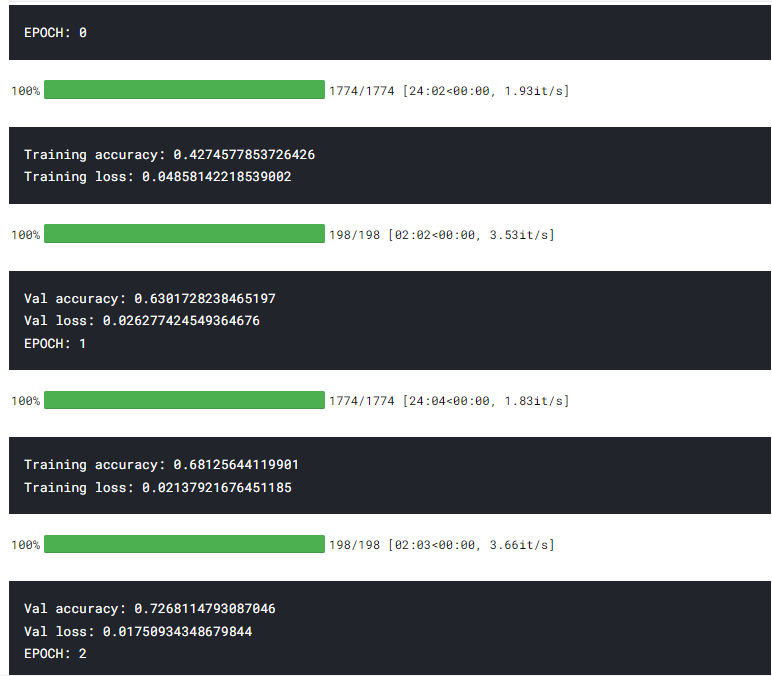[](http://)

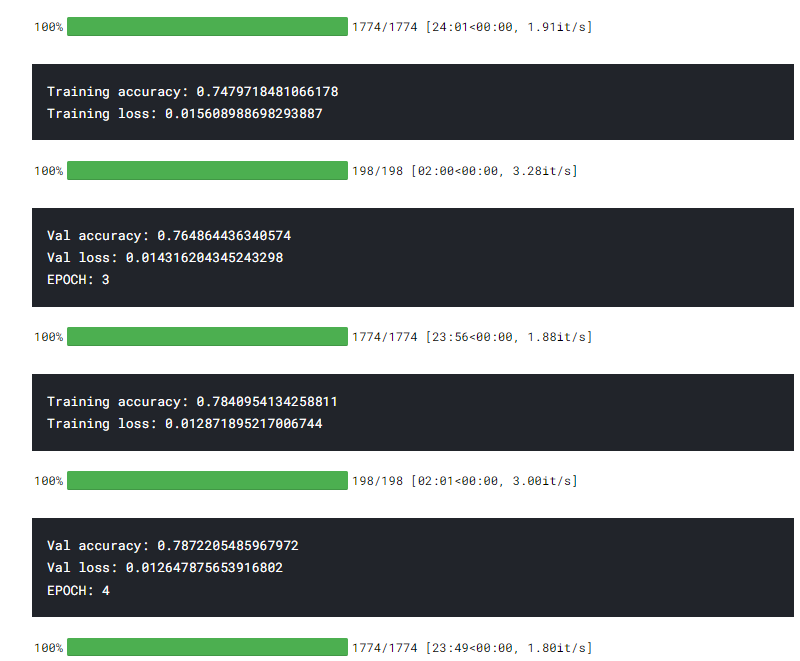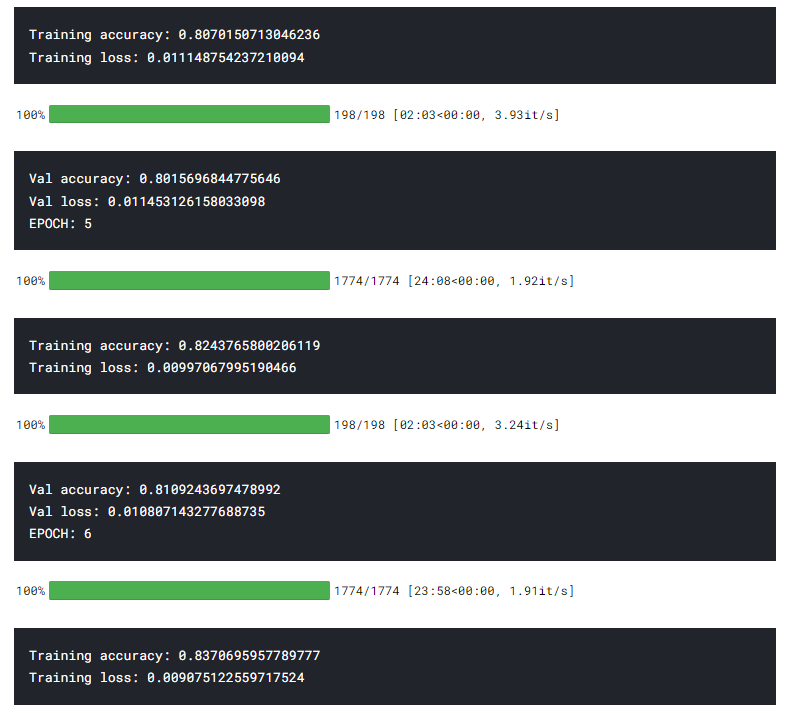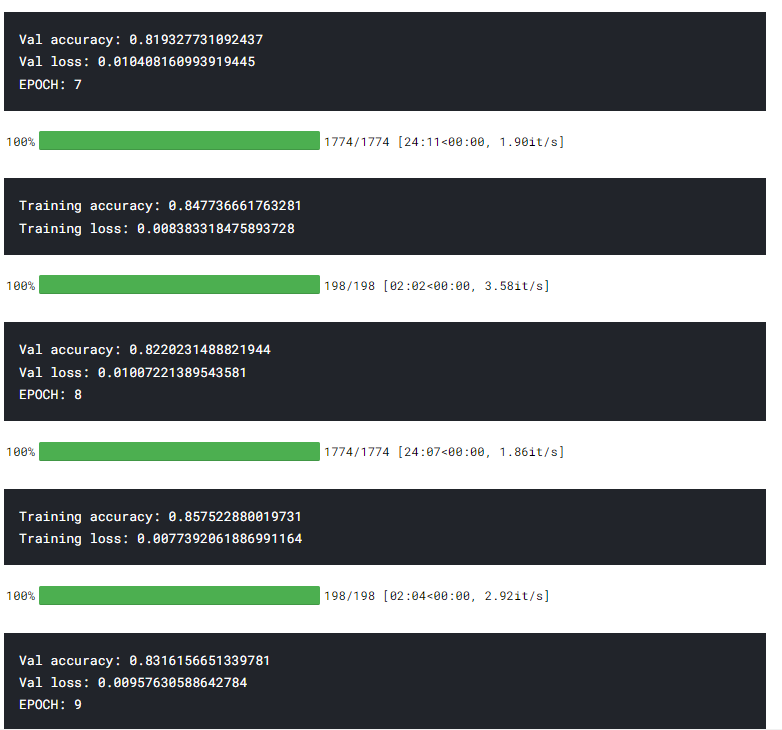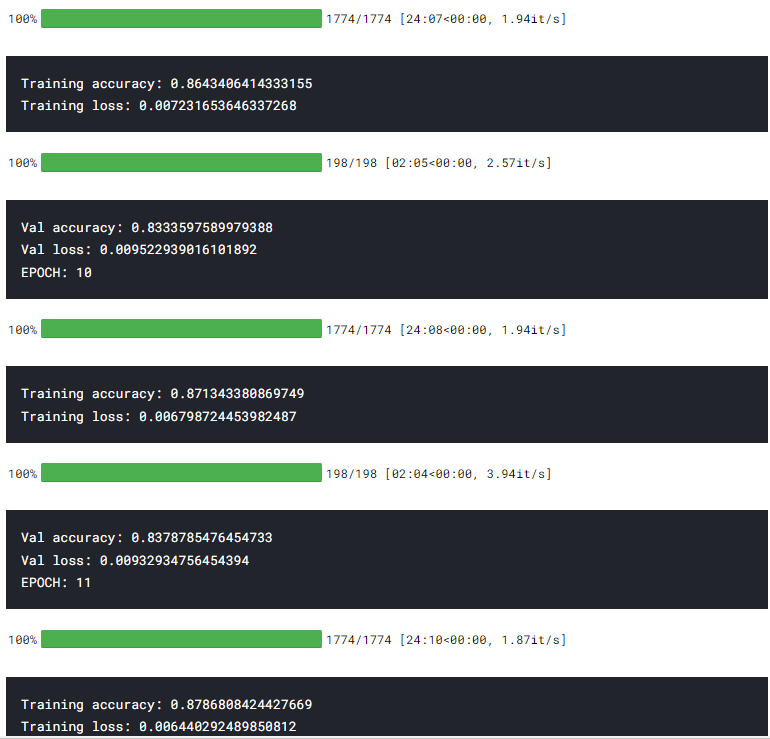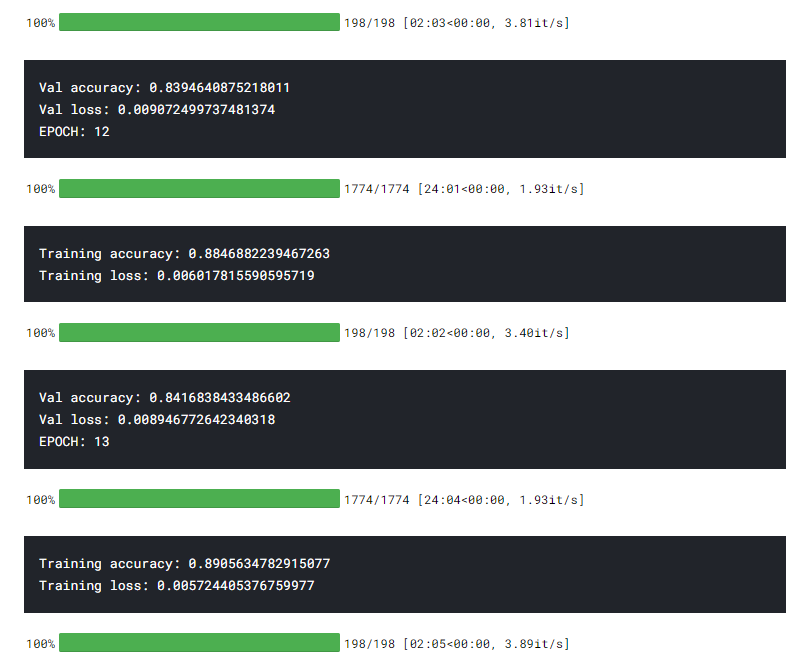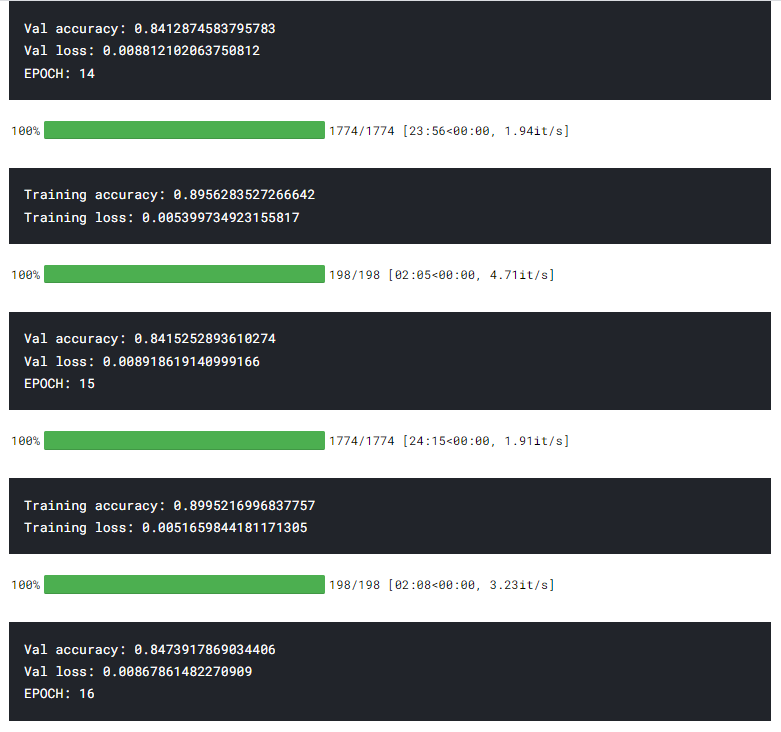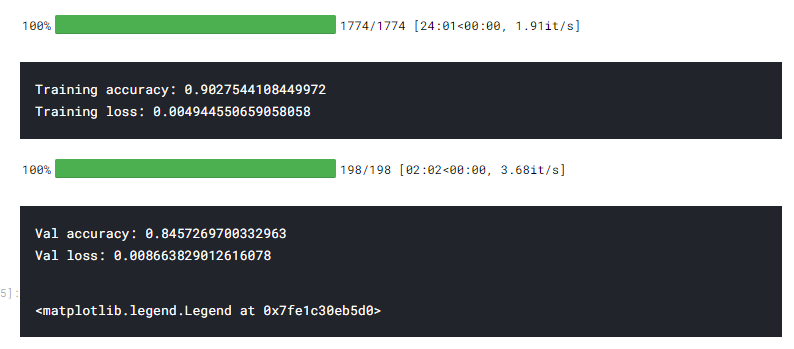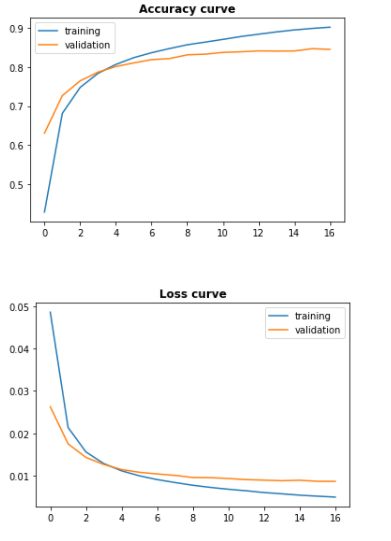

In [ ]:
def generate_csvfile(name, net, transform):
 
    testing_images = sorted(glob.glob("/kaggle/input/polytech-nice-data-science-course-2021/polytech/test/*.jpg"))
    f = open(name + '.csv', 'w')
    f.write("image_name,class\n")
    
    for i in tqdm(range(len(testing_images))):
        img = Image.open(testing_images[i]).convert('RGB') 
        pred = nn.functional.softmax(net(transform(img).unsqueeze(0).cuda()), dim=1).max(1)[1].item() 
        print(pred)
        f.write(os.path.basename(testing_images[i])+','+str(train_data.classes[pred])+'\n')
    f.close()
    
    print("done")

In [ ]:
generate_csvfile('Final_Submission', net, convert)

# **Confusion matrix**

*To better visualize the performance of our model, we decided to plot a confusion matrix so that we have a better idea on how our model is predicting well and which classes it is confused about due many reasons for example, the similarity in plants or the imbalnced dataset.*

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn
def show_confusion_matrix(pred, Y_TEST, classes):

    cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
    cm = normalize(cm,axis=1,norm='l1')

    df_cm = pd.DataFrame(cm, index = classes, columns = classes)

    plt.figure(figsize=(200,200))

    cmap = sn.cubehelix_palette(light=1, as_cmap=True)
    sn.heatmap(df_cm, annot=True,cmap=cmap)
    plt.title('Confusion Matrix',fontdict={'fontsize':20})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show


show_confusion_matrix(preds, y_val, train_data.classes)

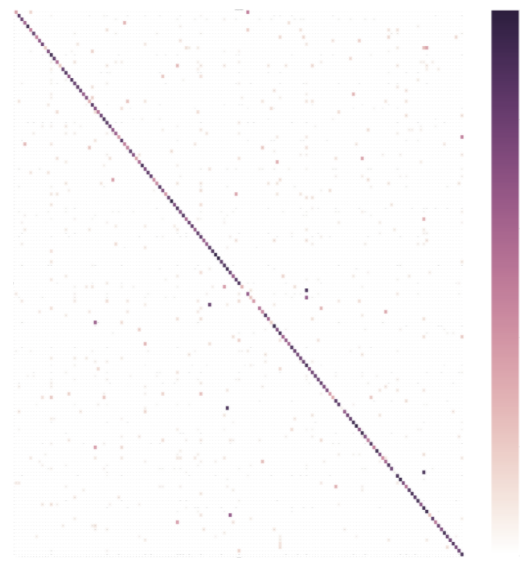

# **Problems we faced**

1. *We were having problems with the testing accuracy. Our models were giving us good training and validation accuracy. But, the testing accuracy was about 1%. So we tried to predict images of the same class which contain trained images to see what's happening. We concluded that the Image Folder function maps the classes to indexes and train accordingly.*

In [ ]:
#names = sorted(glob.glob("/kaggle/input/polytech-nice-data-science-course-2021/polytech/train/1000/*.jpg"))

In [ ]:
#for i in tqdm(range(len(names))):
    #img = Image.open(names[i]).convert('RGB') # load image
    #pred = nn.functional.softmax(net(transformation(img).unsqueeze(0).cuda()), dim=1).max(1)[1].item() # classify image with the neural network
    #print(os.path.basename(str(i+1)+".jpg")+','+str(pred)+','+ str(train_data.classes[pred])+'\n') # write to the output file

2. *Not enough GPU to train with complex models (CUDA out of memory). We were obliged to reduce the batch size to 32 in some models which made the training slower*
